In [ ]:
!pip install emoji


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 14.9 MB/s eta 0:00:00


In [9]:
# ===============================
# 1. Install Required Libraries
# ===============================
!pip install transformers --quiet

# ===============================
# 2. Import Libraries
# ===============================
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import pipeline
import matplotlib.pyplot as plt

# ===============================
# 3. Generate Synthetic Dataset
# ===============================
np.random.seed(42)
num_samples = 1000

df = pd.DataFrame({
    "buffering_time": np.random.uniform(0, 10, size=num_samples),
    "video_quality": np.random.choice(["240p", "360p", "480p", "720p", "1080p"], size=num_samples),
    "watch_duration": np.random.uniform(60, 7200, size=num_samples),
    "chat_message": np.random.choice(
        ['Good stream', 'Laggy video', 'Great quality', 'Buffering issues', 'Nice', 'So boring', 'Excellent', 'Too much lag'],
        size=num_samples
    ),
    "satisfaction_score": np.random.choice([0, 1], size=num_samples)
})

# ===============================
# 4. Clean Text
# ===============================
def clean_text(text):
    text = re.sub(r'http\S+', '', str(text))
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['cleaned_message'] = df['chat_message'].apply(clean_text)

# ===============================
# 5. Sentiment Analysis using BERT
# ===============================
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

sentiments = sentiment_pipeline(df['cleaned_message'].tolist(), batch_size=32)
df['sentiment_label'] = [x['label'] for x in sentiments]
df['sentiment_score'] = [x['score'] for x in sentiments]

# ===============================
# 6. Video Quality Mapping
# ===============================
quality_mapping = {"240p": 1, "360p": 2, "480p": 3, "720p": 4, "1080p": 5}
df["video_quality_num"] = df["video_quality"].map(quality_mapping)

# ===============================
# 7. Prepare Features & Normalize
# ===============================
features = df[["buffering_time", "video_quality_num", "watch_duration", "sentiment_score"]]
labels = df["satisfaction_score"]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# ===============================
# 8. Define and Train DNN Model
# ===============================
class SatisfactionDNN(nn.Module):
    def __init__(self, input_dim):
        super(SatisfactionDNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.LeakyReLU(0.01),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.01),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = SatisfactionDNN(input_dim=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

loss_history = []
for epoch in range(20):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# ===============================
# 9. Evaluation and Accuracy
# ===============================
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

with torch.no_grad():
    predictions = model(X_test_tensor)
    predicted_classes = (predictions > 0.5).float()

# Accuracy
accuracy = accuracy_score(y_test_tensor, predicted_classes)
print(f"\n✅ Test Accuracy: {accuracy:.2f}")

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_test_tensor, predicted_classes))

# Confusion Matrix
print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_test_tensor, predicted_classes))

# ===============================
# 10. Real-Time QoS Decision Example
# ===============================
def simulate_qos_decision(viewer_row):
    input_vector = np.array([[viewer_row["buffering_time"],
                              quality_mapping[viewer_row["video_quality"]],
                              viewer_row["watch_duration"],
                              viewer_row["sentiment_score"]]])
    input_scaled = scaler.transform(input_vector)
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32)
    with torch.no_grad():
        satisfaction_prob = model(input_tensor).item()

    if satisfaction_prob < 0.5:
        action = "⚠️ Switch to lower bitrate to reduce buffering"
    else:
        action = "✅ Maintain current stream quality"

    return satisfaction_prob, action

sample_viewer = df.iloc[10]
satisfaction_prob, action = simulate_qos_decision(sample_viewer)
print(f"\n🧪 Sample Viewer Satisfaction: {satisfaction_prob:.2f}, Action: {action}")

# ===============================
# 11. Tabular Analysis Output
# ===============================
# Summary Stats
print("\n📊 Summary Statistics:")
display(df.describe())

# Sentiment Distribution
print("\n📊 Sentiment Label Distribution:")
display(df['sentiment_label'].value_counts())

# Average Satisfaction per Quality
print("\n📊 Avg Satisfaction by Video Quality:")
display(df.groupby('video_quality')['satisfaction_score'].mean())

# Add predictions to dataframe
df['predicted_satisfaction'] = (model(torch.tensor(features_scaled, dtype=torch.float32)) > 0.5).float()

# Sample Prediction Table
print("\n📊 Sample Predictions Table:")
display(df[['buffering_time', 'video_quality', 'watch_duration', 'sentiment_score',
            'satisfaction_score', 'predicted_satisfaction']].head(10))


Device set to use cuda:0


Epoch 5, Loss: 0.6976
Epoch 10, Loss: 0.6962
Epoch 15, Loss: 0.6951
Epoch 20, Loss: 0.6942

✅ Test Accuracy: 0.52

📊 Classification Report:
              precision    recall  f1-score   support

         0.0       0.29      0.02      0.04        93
         1.0       0.53      0.95      0.68       107

    accuracy                           0.52       200
   macro avg       0.41      0.49      0.36       200
weighted avg       0.42      0.52      0.38       200


📊 Confusion Matrix:
[[  2  91]
 [  5 102]]

🧪 Sample Viewer Satisfaction: 0.54, Action: ✅ Maintain current stream quality

📊 Summary Statistics:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,buffering_time,watch_duration,satisfaction_score,sentiment_score,video_quality_num
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.902566,3659.307096,0.521000,0.999435,3.038000
std,2.921374,2089.478115,0.499809,0.001085,1.431295
min,0.046320,61.345173,0.000000,0.996400,1.000000
25%,2.359733,1784.397535,0.000000,0.999768,2.000000
50%,4.968074,3784.267865,1.000000,0.999843,3.000000
75%,7.443196,5443.875561,1.000000,0.999865,4.000000
max,9.997177,7197.956562,1.000000,0.999878,5.000000



📊 Sentiment Label Distribution:


,count
sentiment_label,
POSITIVE,531
NEGATIVE,469



📊 Avg Satisfaction by Video Quality:


,satisfaction_score
video_quality,
1080p,0.528037
240p,0.533679
360p,0.514151
480p,0.531792
720p,0.500000



📊 Sample Predictions Table:


,buffering_time,video_quality,watch_duration,sentiment_score,satisfaction_score,predicted_satisfaction
0,3.745401,720p,3597.528019,0.999803,0,1.0
1,9.507143,480p,2818.531216,0.999878,0,1.0
2,7.319939,1080p,3273.888447,0.999843,0,1.0
3,5.986585,240p,1680.527918,0.996400,0,0.0
4,1.560186,1080p,6410.251141,0.996400,1,1.0
5,1.559945,240p,3277.424349,0.999768,1,1.0
6,0.580836,360p,6360.760405,0.999865,0,1.0
7,8.661761,240p,814.651447,0.999717,1,1.0
8,6.011150,720p,7116.285435,0.996400,1,1.0
9,7.080726,480p,3224.969844,0.999878,0,1.0


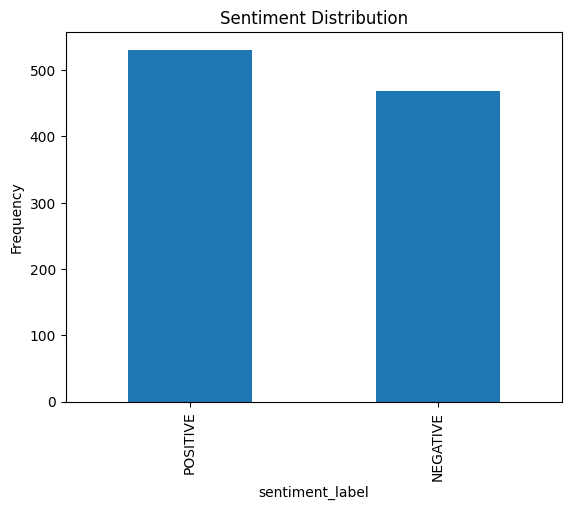

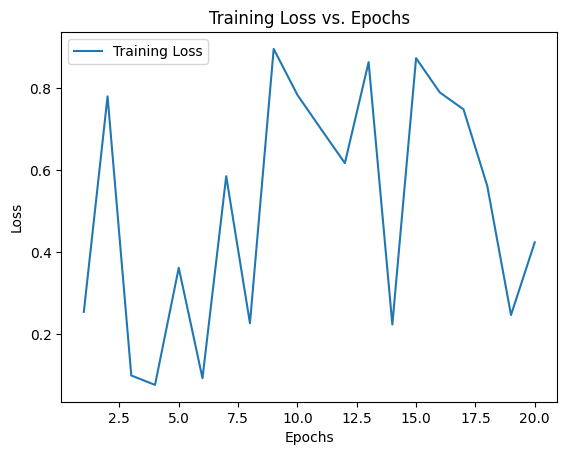

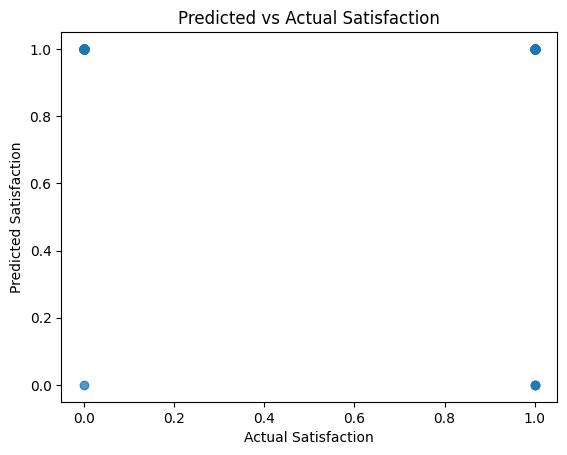

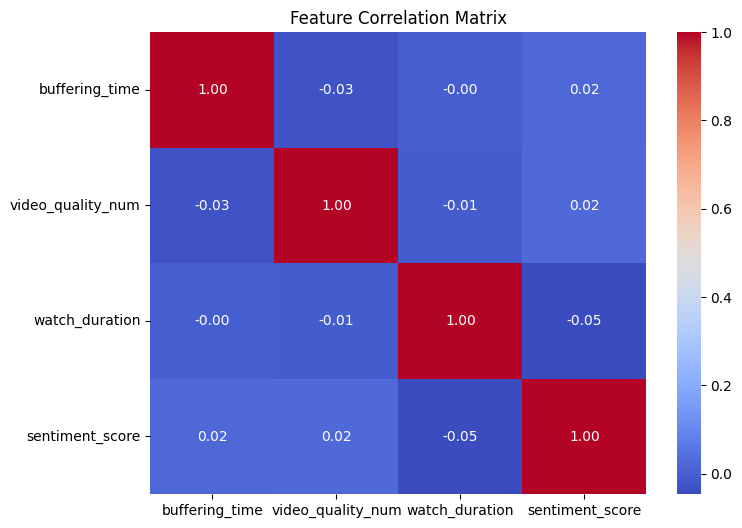

In [10]:
# Sentiment distribution plot
df['sentiment_label'].value_counts().plot(kind='bar', title='Sentiment Distribution')
plt.ylabel('Frequency')
plt.show()
# Example of loss history (if you stored losses in a list during training)
loss_history = []
epochs = 20  # Update based on your training loop
for epoch in range(epochs):
    # Simulating loss values for illustration
    loss_history.append(np.random.random())  # Replace with actual loss values from training loop

# Plotting the loss curve
plt.plot(range(1, epochs + 1), loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.legend()
plt.show()
# Predicted satisfaction vs. Actual satisfaction
plt.scatter(y_test, predicted_classes, alpha=0.5)
plt.xlabel('Actual Satisfaction')
plt.ylabel('Predicted Satisfaction')
plt.title('Predicted vs Actual Satisfaction')
plt.show()
import seaborn as sns

# Correlation matrix
corr_matrix = df[['buffering_time', 'video_quality_num', 'watch_duration', 'sentiment_score']].corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()
